In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textstat

# Amazon Reviews Analysis
## By David Penny

#### Personal Notes

Feature Engineering:

Features to Add | Description | Example
------------- | ------------- | -------------
falsified | The label indicating if the review was falsified or not | 1
rating | The star rating the customer rated the product from 1-5 | 3
verified_purchase | Returns wether or not the customer purchased the product. | 1
sentiment | Returns the overall sentiment of the review. | 0
num_words_in_text | Returns the total number of words in the text | 23
num_stopwords| Returns the total number of stop words. | 12
num_words_in_text_no_stop | Returns the total number of words in the text not counting stop words. | 9
num_unique_words | Returns the number of unique words in the text. | 17
mean_word_len| Returns the average word length in the text. | 4
num_chars| Returns the total number of characters. | 251
num_punctuations| Returns the total number of punctuations. | 4
num_scentences_in_text | Returns the total number of scenctences in the text using textstat library. | 5
flesch_ease| Returns the Flesch Reading Ease Score. | 98.11
flesch_kincaid_grade | Returns the Flesch-Kincaid Grade of the given text. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document. | 9.3
automated_readability_index | Returns the ARI (Automated Readability Index) which outputs a number that approximates the grade level needed to comprehend the text. | 6.5
overall_readability_index| Based upon all the above tests, returns the estimated school grade level required to understand the text. | 8.0
total_sentiment | TBD | TBD
toxic_comment_count | TBD | TBD



Boost Accuracy By:
- Creating feature total_sentiment_analysis by analyzing the sentiment contained in each scentence - NLP on each scentence and using recurrent neural tensor networks (RNTNs) to determine each scentence sentiment.
- Creating feature toxic_comments_count (toxic+severe_toxic+obscene+threat+insult+identity_hate) - Kaggle Challenge

Consider:
- Scaling data
- KNN, Decision Trees, Support Vector Machines
- PCA
- Model Evaluation
- HyperParameter Optimization for each
- K-Means, GMM, t-SNE clustering
- Neural Networks - recurrent neural tensor networks (RNTNs)

### 1. Data Ingest, Check and Cleanup

In [249]:
df = pd.read_csv('data/labeled_amazon_reviews.txt', sep="\t")
df.columns = ["doc_id", "falsified", "rating", "verified_purchase", "product_category", "product_id", "product_title","review_title","review_text"]

In [250]:
df.head(10)

,doc_id,falsified,rating,verified_purchase,product_category,product_id,product_title,review_title,review_text
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...
5,6,__label1__,3,N,Health & Personal Care,B00686HNUK,Tobacco Pipe Stand - Fold-away Portable - Ligh...,not sure,I'm not sure what this is supposed to be but I...
6,7,__label1__,4,N,Toys,B00NUG865W,ESPN 2-Piece Table Tennis,PING PONG TABLE GREAT FOR YOUTHS AND FAMILY,Pleased with ping pong table. 11 year old and ...
7,8,__label1__,4,Y,Beauty,B00QUL8VX6,Abundant Health 25% Vitamin C Serum with Vitam...,Great vitamin C serum,Great vitamin C serum... I really like the oil...
8,9,__label1__,4,N,Health & Personal Care,B004YHKVCM,PODS Spring Meadow HE Turbo Laundry Detergent ...,wonderful detergent.,I've used tide pods laundry detergent for many...
9,10,__label1__,1,N,Health & Personal Care,B00H4IBD0M,"Sheer TEST, Best Testosterone Booster Suppleme...",WARNING: do not waste your money on this,Everybody wants to fall for their promises. Bu...


In [251]:
df.shape

(21000, 9)

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   doc_id             21000 non-null  int64 
 1   falsified          21000 non-null  object
 2   rating             21000 non-null  int64 
 3   verified_purchase  21000 non-null  object
 4   product_category   21000 non-null  object
 5   product_id         21000 non-null  object
 6   product_title      21000 non-null  object
 7   review_title       21000 non-null  object
 8   review_text        21000 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


In [253]:
# Check for NA's
def display_NA_counts(the_df):
    null_series = the_df.isna().sum(axis=0)
    display(null_series[null_series > 0])

In [254]:
display_NA_counts(df)

Series([], dtype: int64)

In [255]:
#Check for duplicated rows
df.duplicated().sum()*100.0/df.shape[0]

0.0

In [256]:
def get_verified_value(value):
    if value == 'Y':
        return 1
    else:
        return 0

In [257]:
df['verified_purchase'] = df['verified_purchase'].apply(get_verified_value)

In [258]:
df.head()

,doc_id,falsified,rating,verified_purchase,product_category,product_id,product_title,review_title,review_text
0,1,__label1__,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,0,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,0,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


In [259]:
def get_label(value):
    if value == '__label1__':
        return 1
    else:
        return 0

In [260]:
df['falsified'] = df['falsified'].apply(get_label)

In [261]:
df.head()

,doc_id,falsified,rating,verified_purchase,product_category,product_id,product_title,review_title,review_text
0,1,1,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,1,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,1,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,1,4,0,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,1,4,0,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


In [262]:
def get_sentiment(value):
    if value > 3:
        return 1
    else:
        return 0

In [263]:
df['sentiment'] = df['rating'].apply(get_sentiment)

In [264]:
df.head()

,doc_id,falsified,rating,verified_purchase,product_category,product_id,product_title,review_title,review_text,sentiment
0,1,1,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",1
1,2,1,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,1
2,3,1,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,0
3,4,1,4,0,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,1
4,5,1,4,0,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,1


In [265]:
#Removing ratings with rating = 3 ("On the fence")
# df = df.loc[:, ['review_body', 'star_rating']]
# df = df.query('star_rating != 3.0')
# df.head()

### 2. Preliminary EDA

5    12210
4     3973
3     1868
1     1757
2     1192
Name: rating, dtype: int64


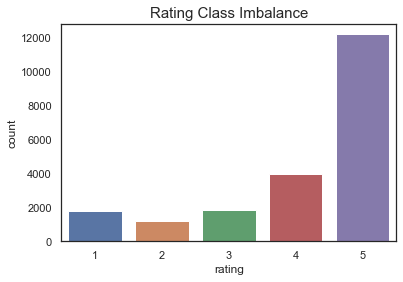

In [278]:
sns.countplot(x='rating', data=df)
plt.title('Rating Class Imbalance', size=15)
print(df['rating'].value_counts())

1    16183
0     4817
Name: sentiment, dtype: int64


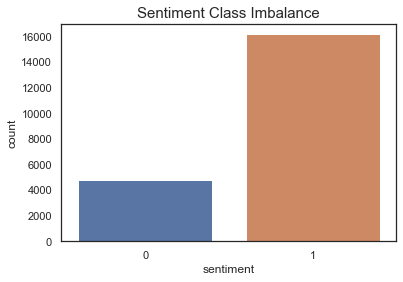

In [275]:
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Class Imbalance', size=15)
print(df['sentiment'].value_counts())

1    10500
0    10500
Name: falsified, dtype: int64


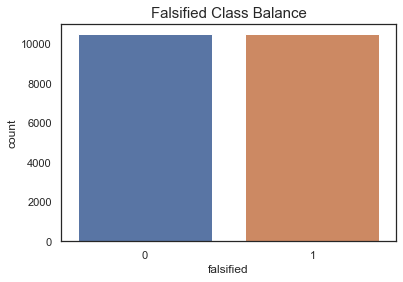

In [280]:
sns.countplot(x='falsified', data=df)
plt.title('Falsified Class Balance', size=15)
print(df['falsified'].value_counts())

In [145]:
# df.query('falsified == 1')

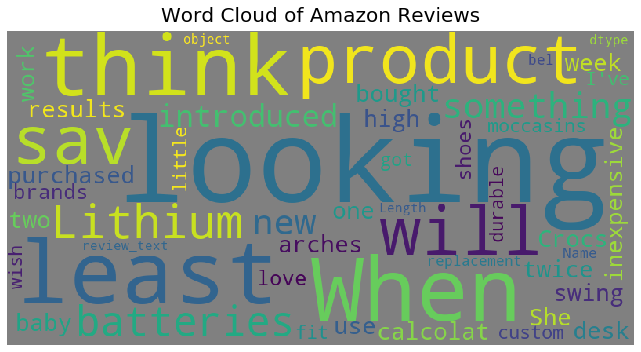

In [146]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=150, figure_size=(15.0,5.0), 
                   title = None, title_size=20, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='gray',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 50,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df['review_text'], title="Word Cloud of Amazon Reviews")

In [147]:
# Let's clean out any html (should it exist)
import bs4
df['review_text'] = df['review_text'].apply(lambda x: bs4.BeautifulSoup(x, 'lxml').get_text())

In [148]:
df.head()

,doc_id,falsified,rating,verified_purchase,product_category,product_id,product_title,review_title,review_text,sentiment
0,1,1,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",1
1,2,1,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,1
2,3,1,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,0
3,4,1,4,0,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,1
4,5,1,4,0,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,1


In [149]:
df_clean = df

In [150]:
df = df_clean

### 3. Feature Extraction

In [151]:
import string

## Number of words in the text ##
df["num_words_in_text"] = df["review_text"].apply(lambda x: len(str(x).split()))

## Number of stopwords in the text ##
df["num_stopwords"] = df["review_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of words in the text (not counting stopwords) ##
df["num_words_in_text_no_stop"] = df.apply(lambda x: x['num_words_in_text'] - x['num_stopwords'], axis=1)

## Number of unique words in the text ##
df["num_unique_words"] = df["review_text"].apply(lambda x: len(set(str(x).split())))

## Average length of the words in the text ##
df["mean_word_len"] = df["review_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

## Number of characters in the text ##
df["num_chars"] = df["review_text"].apply(lambda x: len(str(x)))

## Number of punctuations in the text ##
df["num_punctuations"] = df['review_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [152]:
## Number of Scentences ##
df["num_scentences_in_text"] = df["review_text"].apply(lambda x: textstat.sentence_count(x))

## Flesch Reading Ease Formula ##
df["flesch_ease"] = df["review_text"].apply(lambda x: textstat.flesch_reading_ease(x))

## Flesh-Kincaid Grade Level ##
df["flesch_kincaid_grade"] = df["review_text"].apply(lambda x: textstat.flesch_kincaid_grade(x))

## Automated Readability Index ##
df["automated_readability_index"] = df["review_text"].apply(lambda x: textstat.automated_readability_index(x))

## Overall Readability Index ##
df["overall_readability_index"] = df["review_text"].apply(lambda x: textstat.text_standard(x, float_output=True))

In [177]:
df.head(1)

,doc_id,falsified,rating,verified_purchase,product_category,product_id,product_title,review_title,review_text,sentiment,...,num_words_in_text_no_stop,num_unique_words,mean_word_len,num_chars,num_punctuations,num_scentences_in_text,flesch_ease,flesch_kincaid_grade,automated_readability_index,overall_readability_index
0,1,1,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",1,...,12,21,4.09,116,3,2,102.10,1.90,3.60,5.00


In [178]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
doc_id,21000.00,10500.50,6062.32,1.00,5250.75,10500.50,15750.25,21000.00
falsified,21000.00,0.50,0.50,0.00,0.00,0.50,1.00,1.00
rating,21000.00,4.13,1.28,1.00,4.00,5.00,5.00,5.00
verified_purchase,21000.00,0.56,0.50,0.00,0.00,1.00,1.00,1.00
sentiment,21000.00,0.77,0.42,0.00,1.00,1.00,1.00,1.00
num_words_in_text,21000.00,68.45,84.25,1.00,29.00,44.00,73.00,2805.00
num_stopwords,21000.00,34.00,40.97,0.00,14.00,23.00,37.00,1423.00
num_words_in_text_no_stop,21000.00,34.45,43.98,1.00,15.00,22.00,36.00,1382.00
num_unique_words,21000.00,51.27,46.06,1.00,26.00,38.00,57.00,992.00
mean_word_len,21000.00,4.35,0.73,3.09,4.06,4.30,4.58,64.00


In [209]:
## Truncate some extreme values for better visuals, think about balancing positive vs negative reviews ##
df_final = df.query('num_words_in_text <= 500 and num_punctuations < 300')

In [210]:
df_final.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
doc_id,20862.00,10488.65,6070.71,1.00,5226.25,10455.50,15754.75,21000.00
falsified,20862.00,0.50,0.50,0.00,0.00,1.00,1.00,1.00
rating,20862.00,4.13,1.28,1.00,4.00,5.00,5.00,5.00
verified_purchase,20862.00,0.56,0.50,0.00,0.00,1.00,1.00,1.00
sentiment,20862.00,0.77,0.42,0.00,1.00,1.00,1.00,1.00
num_words_in_text,20862.00,64.05,60.61,1.00,29.00,44.00,72.00,500.00
num_stopwords,20862.00,31.94,30.20,0.00,14.00,22.00,37.00,255.00
num_words_in_text_no_stop,20862.00,32.12,31.14,1.00,15.00,22.00,35.00,339.00
num_unique_words,20862.00,49.09,36.55,1.00,26.00,38.00,57.00,319.00
mean_word_len,20862.00,4.35,0.73,3.09,4.06,4.30,4.57,64.00


In [211]:
df_final.to_csv('df_final.csv');

In [109]:
# # Using recurrent neural tensor networks (RNTNs) to determine each scentence sentiment.
# # 𝑇𝑜𝑡𝑎𝑙 𝑆𝑒𝑛𝑡𝑖𝑚𝑒𝑛𝑡 = 1 ∗ (𝑉𝑒𝑟𝑦 𝑁𝑒𝑔𝑎𝑡𝑖𝑣𝑒) + 2 ∗ (𝑁𝑒𝑔𝑎𝑡𝑖𝑣𝑒) + 3 ∗ (𝑁𝑒𝑢𝑡𝑟𝑎𝑙) + 4 ∗ (𝑃𝑜𝑠𝑖𝑡𝑖𝑣𝑒) + 5 ∗ (𝑉𝑒𝑟𝑦 𝑃𝑜𝑠𝑖𝑡𝑖𝑣𝑒)

# df_mini = df([['doc_id','review_body']])

# def get_total_sentiment(value):
#     if value > 3:
#         return 1
#     else:
#         return 0
    
# df['total_sentiment'] = df['review_text'].apply(get_sentiment)

### 4. Corrolation Check and VIF Check

In [ ]:
df_numerical = df[['falsified','rating','verified_purchase','sentiment','num_words_in_text','num_stopwords',\
                  'num_words_in_text_no_stop', 'num_unique_words', 'mean_word_len','num_chars',\
                  'num_punctuations','num_scentences_in_text', 'flesch_ease', 'flesch_kincaid_grade',\
                  'automated_readability_index','overall_readability_index']]

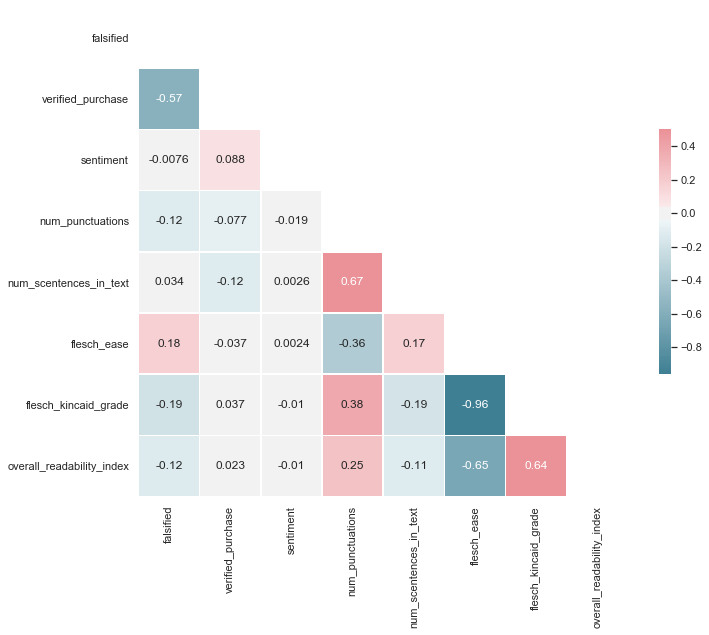

In [365]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#df_corr = df_numerical
df_corr = low_vif_df_numerical

sns.set(style="white")

# Compute the correlation matrix
corr = df_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=corr)

In [338]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

vif_df_numerical = df_numerical

#Lets take a look at the Varience Inflation Factor on ONLY low corrolated columns
VIF = []

vif_df_numerical = vif_df_numerical.drop('num_words_in_text', axis=1)
vif_df_numerical = vif_df_numerical.drop('num_stopwords', axis=1)
vif_df_numerical = vif_df_numerical.drop('num_words_in_text_no_stop', axis=1)
vif_df_numerical = vif_df_numerical.drop('automated_readability_index', axis=1)
vif_df_numerical = vif_df_numerical.drop('num_unique_words', axis=1)
vif_df_numerical = vif_df_numerical.drop('mean_word_len', axis=1)
vif_df_numerical = vif_df_numerical.drop('rating', axis=1)
vif_df_numerical = vif_df_numerical.drop('num_chars', axis=1)

for i in vif_df_numerical:
    X = vif_df_numerical[[
        'falsified',
        #'rating',
        'verified_purchase',
        'sentiment',
        #'num_words_in_text',
        #'num_stopwords',
        #'num_words_in_text_no_stop', 
        #'num_unique_words', 
        #'mean_word_len',
        #'num_chars',
        'num_punctuations',
        'num_scentences_in_text', 
        'flesch_ease', 
        'flesch_kincaid_grade',
        #'automated_readability_index',
        'overall_readability_index'
        ]]
    
    low_vif_df_numerical = X
    y = vif_df_numerical['sentiment']
    
    X_withconst = sm.add_constant(X)
    
    #Lets store our results
    VIF = pd.Series([variance_inflation_factor(X.values, i) 
        for i in range(X.shape[1])],index=X.columns)
    
    #Lets make a pretty table to show our results
    pd.options.display.float_format = '{:.2f}'.format
    
VIF_Frame = pd.DataFrame(VIF, columns=['VIF Value'])

VIF_Frame

,VIF Value
falsified,2.97
verified_purchase,3.29
sentiment,4.23
num_punctuations,5.06
num_scentences_in_text,5.79
flesch_ease,6.93
flesch_kincaid_grade,5.25
overall_readability_index,2.88


### 5. Preliminary Modeling

In [339]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [340]:
print(df.columns)

Index(['doc_id', 'falsified', 'rating', 'verified_purchase',
       'product_category', 'product_id', 'product_title', 'review_title',
       'review_text', 'sentiment'],
      dtype='object')


In [341]:
y = low_vif_df_numerical['falsified']
X = low_vif_df_numerical.drop(columns='falsified')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(y.shape)
print(X.shape)

(21000,)
(21000, 7)


In [342]:
X_withconstant = sm.add_constant(X)

my_logit_results = sm.Logit(y, X_withconstant).fit()
my_logit_results.summary()

Optimization terminated successfully.
         Current function value: 0.481039
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              falsified   No. Observations:                21000
Model:                          Logit   Df Residuals:                    20992
Method:                           MLE   Df Model:                            7
Date:                Fri, 19 Jun 2020   Pseudo R-squ.:                  0.3060
Time:                        09:30:32   Log-Likelihood:                -10102.
converged:                       True   LL-Null:                       -14556.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.7099      0.190     14.275      0.000       2.338       3.082
verified_purchase            -2.8852      0.038    -75.173      0.000      -2.960      -2.810
sentiment                     0.2962      0.043      6.866      0.000       0.212       0.381
num_punctuations             -0.0433      0.003    -14.991      0.000      -0.049      -0.038
num_scentences_in_text        0.0628      0.010      6.106      0.000       0.043       0.083
flesch_ease                  -0.0071      0.002     -3.991      0.000      -0.011      -0.004
flesch_kincaid_grade         -0.0530      0.006     -9.259      0.000      -0.064      -0.042
overall_readability_index    -0.0035      0.004     -0.953      0.341      -0.011       0.004
=============================================================================================
"""

### 6. Class Imbalance + Downsampling DF

1    16183
0     4817
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Sentiment Counts')

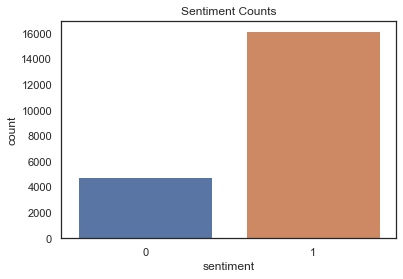

In [343]:
print(low_vif_df_numerical['sentiment'].value_counts())
sns.countplot(x='sentiment', data=low_vif_df_numerical)
plt.title("Sentiment Counts")

In [344]:
from sklearn.utils import resample

positive = low_vif_df_numerical[low_vif_df_numerical['sentiment']==1]
negative = low_vif_df_numerical[low_vif_df_numerical['sentiment']==0]

positive_downsampled = resample(positive,
                                replace = False, # sample without replacement
                                n_samples = len(negative), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([positive_downsampled, negative])

df_downsampled = downsampled

1    4817
0    4817
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Sentiment Counts')

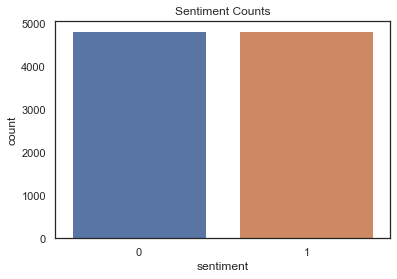

In [345]:
print(df_downsampled['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df_downsampled)
plt.title("Sentiment Counts")

### 7. Clustering

In [346]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [347]:
# tSNE with two components
X = df_downsampled
y = df_downsampled['falsified']

# We need to scale the data since tSNE is also distance based
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

my_tSNE = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

X_tSNE = my_tSNE.fit_transform(X_scaled)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9634 samples in 0.007s...
[t-SNE] Computed neighbors for 9634 samples in 0.683s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9634
[t-SNE] Computed conditional probabilities for sample 2000 / 9634
[t-SNE] Computed conditional probabilities for sample 3000 / 9634
[t-SNE] Computed conditional probabilities for sample 4000 / 9634
[t-SNE] Computed conditional probabilities for sample 5000 / 9634
[t-SNE] Computed conditional probabilities for sample 6000 / 9634
[t-SNE] Computed conditional probabilities for sample 7000 / 9634
[t-SNE] Computed conditional probabilities for sample 8000 / 9634
[t-SNE] Computed conditional probabilities for sample 9000 / 9634
[t-SNE] Computed conditional probabilities for sample 9634 / 9634
[t-SNE] Mean sigma: 0.161962
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.412323
[t-SNE] KL divergence after 300 iterations: 2.040689


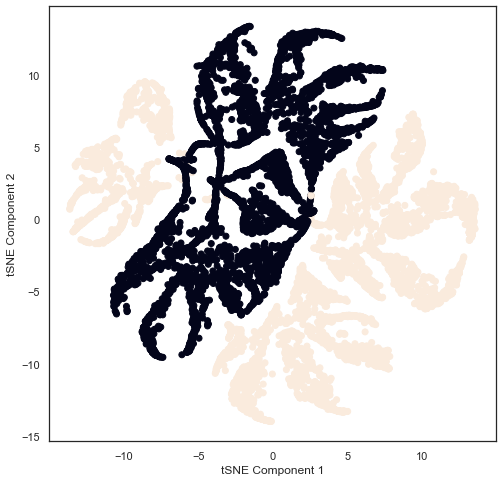

In [348]:
# Plotting the tSNE-transformed data (only the first two dimensions)
plt.figure(figsize=(8, 8))
plt.scatter(X_tSNE[:,0],X_tSNE[:,1],c=y)

plt.xlabel("tSNE Component 1")
plt.ylabel("tSNE Component 2")

plt.show()

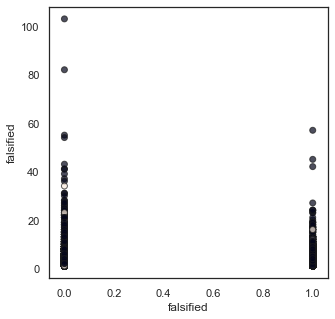

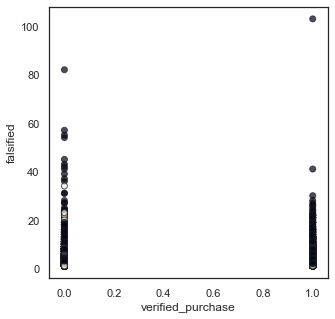

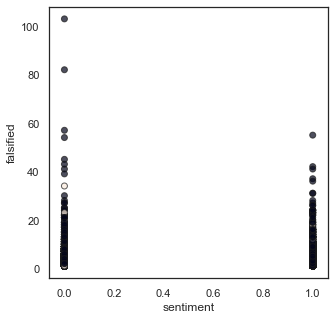

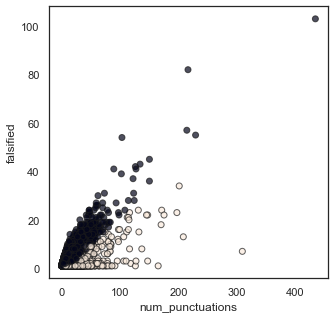

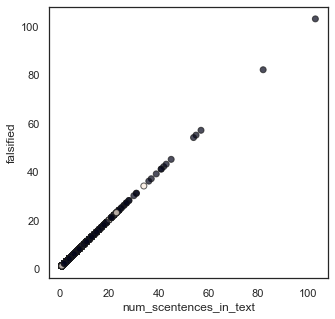

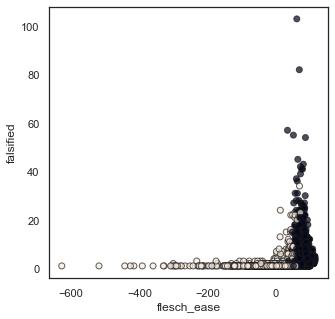

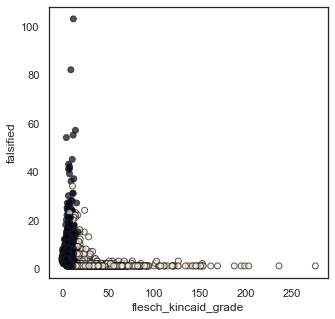

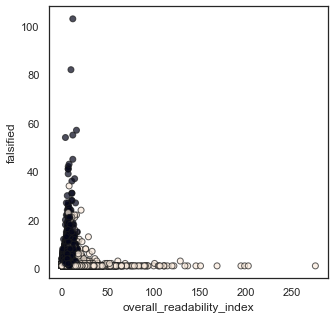

In [349]:
from sklearn.mixture import GaussianMixture

X = df_downsampled
y = df_downsampled['falsified']

#Build and fit the model
my_gmm = GaussianMixture(n_components=2, covariance_type='full')
my_gmm.fit(X)

#Getting the labels
pred_labels_gmm = my_gmm.predict(X)

for column in df_downsampled:
    #Plot the predictions
    plt.figure(figsize=[5,5])
    plt.scatter(x = df_downsampled[column],
                y = df_downsampled['num_scentences_in_text'],
                c=pred_labels_gmm, 
                edgecolor='k',
                alpha=0.7)
    plt.xlabel(column)
    plt.ylabel('falsified')
    plt.show();

### 8. Model Selection & Detailed Data Modeling

In [350]:
y = df_downsampled['falsified']
X = df_downsampled.drop(columns='falsified')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(y.shape)
print(X.shape)

(9634,)
(9634, 7)


In [351]:
X_withconstant = sm.add_constant(X)

my_logit_results = sm.Logit(y, X_withconstant).fit()
my_logit_results.summary()

Optimization terminated successfully.
         Current function value: 0.456106
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              falsified   No. Observations:                 9634
Model:                          Logit   Df Residuals:                     9626
Method:                           MLE   Df Model:                            7
Date:                Fri, 19 Jun 2020   Pseudo R-squ.:                  0.3420
Time:                        09:31:18   Log-Likelihood:                -4394.1
converged:                       True   LL-Null:                       -6677.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         3.0000      0.384      7.821      0.000       2.248       3.752
verified_purchase            -3.1019      0.058    -53.698      0.000      -3.215      -2.989
sentiment                     0.3251      0.055      5.912      0.000       0.217       0.433
num_punctuations             -0.0343      0.004     -8.207      0.000      -0.042      -0.026
num_scentences_in_text        0.0222      0.016      1.411      0.158      -0.009       0.053
flesch_ease                  -0.0076      0.004     -2.006      0.045      -0.015      -0.000
flesch_kincaid_grade         -0.0576      0.011     -5.204      0.000      -0.079      -0.036
overall_readability_index    -0.0097      0.006     -1.729      0.084      -0.021       0.001
=============================================================================================
"""

In [366]:
coefficients = my_logit_results.params
coefficients.head()

const                     3.00
verified_purchase        -3.10
sentiment                 0.33
num_punctuations         -0.03
num_scentences_in_text    0.02
dtype: float64

In [367]:
p_values = my_logit_results.pvalues
p_values.head()

const                    0.00
verified_purchase        0.00
sentiment                0.00
num_punctuations         0.00
num_scentences_in_text   0.16
dtype: float64

In [368]:
coefficient_df = pd.DataFrame({"coefficient": coefficients,
                               "p-value": p_values})
print(coefficient_df.shape)
coefficient_df.head()

(8, 2)


,coefficient,p-value
const,3.00,0.00
verified_purchase,-3.10,0.00
sentiment,0.33,0.00
num_punctuations,-0.03,0.00
num_scentences_in_text,0.02,0.16


In [369]:
coefficient_df.drop('const', axis=0, inplace=True)
coefficient_df.head()

,coefficient,p-value
verified_purchase,-3.10,0.00
sentiment,0.33,0.00
num_punctuations,-0.03,0.00
num_scentences_in_text,0.02,0.16
flesch_ease,-0.01,0.04


In [370]:
statistically_significant_condition = coefficient_df['p-value'] < 0.05

significant_coefficient_df = coefficient_df.loc[statistically_significant_condition].copy()
significant_coefficient_df.shape

(5, 2)

In [371]:
significant_coefficient_df['abs_coef'] = np.abs(significant_coefficient_df['coefficient'])
significant_coefficient_df = significant_coefficient_df.sort_values(by='abs_coef')
significant_coefficient_df

,coefficient,p-value,abs_coef
flesch_ease,-0.01,0.04,0.01
num_punctuations,-0.03,0.00,0.03
flesch_kincaid_grade,-0.06,0.00,0.06
sentiment,0.33,0.00,0.33
verified_purchase,-3.10,0.00,3.10


In [372]:
significant_coefficient_df['color'] = np.where(significant_coefficient_df['coefficient'] >= 0.0,
                                               'blue', 
                                               'red')
significant_coefficient_df.head()

,coefficient,p-value,abs_coef,color
flesch_ease,-0.01,0.04,0.01,red
num_punctuations,-0.03,0.00,0.03,red
flesch_kincaid_grade,-0.06,0.00,0.06,red
sentiment,0.33,0.00,0.33,blue
verified_purchase,-3.10,0.00,3.10,red


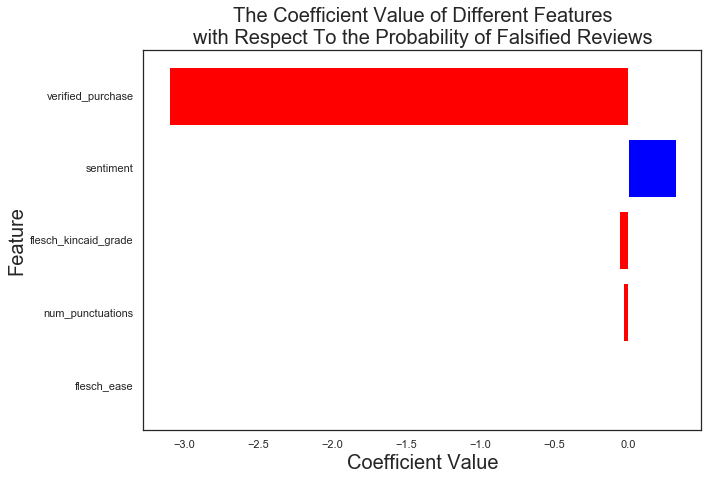

In [384]:
plt.figure(figsize=(10,7))
plt.barh(significant_coefficient_df.index, 
         significant_coefficient_df['coefficient'],
         color=significant_coefficient_df['color'])
plt.title("The Coefficient Value of Different Features\nwith Respect To the Probability of Falsified Reviews",
          size=20)
plt.xlabel("Coefficient Value", size=20)
plt.ylabel("Feature", size=20)
plt.show()

In [385]:
significant_coefficient_df['odds_increase'] = np.where(significant_coefficient_df['coefficient'] > 0,
                                                       np.exp(significant_coefficient_df['coefficient']),
                                                       np.exp(-significant_coefficient_df['coefficient']))
significant_coefficient_df.head() 

,coefficient,p-value,abs_coef,color,odds_increase
flesch_ease,-0.01,0.04,0.01,red,1.01
num_punctuations,-0.03,0.00,0.03,red,1.03
flesch_kincaid_grade,-0.06,0.00,0.06,red,1.06
sentiment,0.33,0.00,0.33,blue,1.38
verified_purchase,-3.10,0.00,3.10,red,22.24


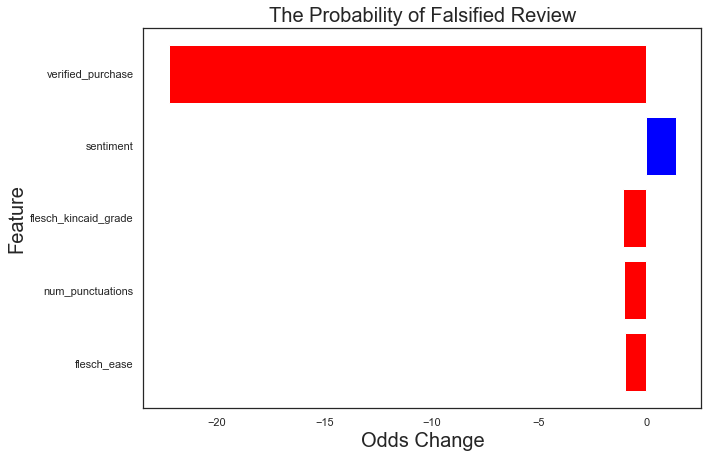

In [386]:
significant_coefficient_df['odds_increase'] = np.where(significant_coefficient_df['coefficient'] > 0,
                                                       significant_coefficient_df['odds_increase'],
                                                       -significant_coefficient_df['odds_increase'])


plt.figure(figsize=(10,7))
plt.barh(significant_coefficient_df.index, 
         significant_coefficient_df['odds_increase'],
         color=significant_coefficient_df['color'])
plt.title("The Probability of Falsified Review",
          size=20)
plt.xlabel("Odds Change", size=20)
plt.ylabel("Feature", size=20)
plt.show()

#### Logistic Regression

In [352]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = df_downsampled
y = df_downsampled['falsified']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [356]:
#Fit a logistic regression model
logreg_model = LogisticRegression(penalty='l2', max_iter=10000)
logreg_model.fit(X_train, y_train)

#Score it
train_prediction = logreg_model.predict(X_train)
test_prediction = logreg_model.predict(X_test)
accuracy_train = accuracy_score(train_prediction, y_train)
accuracy_test = accuracy_score(test_prediction, y_test)

print(f"Score on training set: {accuracy_train}")
print(f"Score on test set: {accuracy_test}")

#PlotBoundaries(logreg_model, X, y, plotsize=(10,7))

Score on training set: 1.0
Score on test set: 1.0


#### K-Nearest Neighbors

In [357]:
from sklearn.neighbors import KNeighborsClassifier

# Split our data into train & test sets

# Instantiate the model & fit it to our data
KNN_model = KNeighborsClassifier(n_neighbors=3, weights='distance' )
KNN_model.fit(X_train, y_train)

# Score the model on the test set
test_predictions = KNN_model.predict(X_test)
test_accuracy = accuracy_score(test_predictions, y_test)
print(f"Test set accuracy: {test_accuracy}")

Test set accuracy: 0.820965230928905


#### Decision Tree

In [358]:
from sklearn.tree import DecisionTreeClassifier

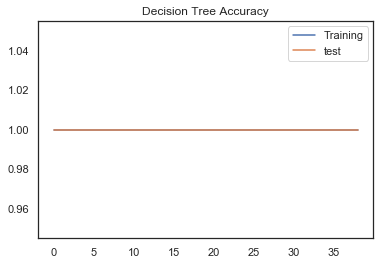

In [359]:
training_scores = []
test_scores = []

for i in range(1,40):
    # Instantiate & fit the DT
    DT_model = DecisionTreeClassifier(max_depth=i, max_leaf_nodes=100)
    DT_model.fit(X_train, y_train)
    
    training_scores.append(DT_model.score(X_train, y_train))
    test_scores.append(DT_model.score(X_test, y_test))

plt.figure()
plt.title('Decision Tree Accuracy')
plt.plot(training_scores)
plt.plot(test_scores)
plt.legend(['Training', 'test'])

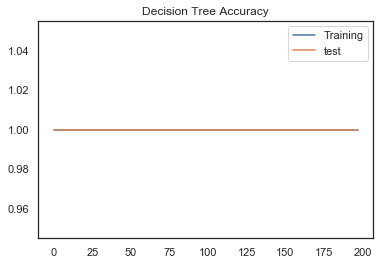

In [360]:
training_scores = []
test_scores = []

for i in range(2,200):
    # Instantiate & fit the DT
    DT_model = DecisionTreeClassifier(max_depth=19, max_leaf_nodes=i)
    DT_model.fit(X_train, y_train)
    
    training_scores.append(DT_model.score(X_train, y_train))
    test_scores.append(DT_model.score(X_test, y_test))

plt.figure()
plt.title('Decision Tree Accuracy')
plt.plot(training_scores)
plt.plot(test_scores)
plt.legend(['Training', 'test'])

In [361]:
# Instantiate & fit the DT
DT_model = DecisionTreeClassifier(max_depth = 4, max_leaf_nodes=20)
DT_model.fit(X_train, y_train) 

# Evaluate its classification accuracy (Just on the training set for now)
print(f"DT training set accuracy: {DT_model.score(X_train, y_train)}")
print(f"DT test set accuracy: {DT_model.score(X_test, y_test)}")

DT training set accuracy: 1.0
DT test set accuracy: 1.0


#### Support Vector Machines

In [364]:
from sklearn.svm import LinearSVC

SVM_model = LinearSVC(max_iter=1000000)
SVM_model.fit(X_train, y_train)

print(f"The TRAIN classification accuracy is: {SVM_model.score(X_train,y_train)}")
print(f"The TEST classification accuracy is: {SVM_model.score(X_test,y_test)}")

The TRAIN classification accuracy is: 1.0
The TEST classification accuracy is: 1.0


/Users/davepenny/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [363]:
from sklearn.svm import SVC

my_RBF_kernel_SVM = SVC()
my_linear_kernel_SVM = SVC(kernel='linear')

#Fit the data
my_linear_kernel_SVM.fit(X_train, y_train)

#Get the score
print(f"Linear SVM score (train): {my_linear_kernel_SVM.score(X_train,y_train)}")
print(f"Linear SVM score (test): {my_linear_kernel_SVM.score(X_test,y_test)}")

Linear SVM score (train): 1.0
Linear SVM score (test): 1.0


### 9. Model Tuning and Selection

In [308]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [313]:
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=1)

In [314]:
my_pipeline = Pipeline([('scalar', StandardScaler()), ('dim_reducer', PCA()), ('model', DecisionTreeClassifier)])

In [318]:
# Parameter grid 
dt_params2 = [
    
    #without PCA 
    {'scalar': [None], 
    'dim_reducer' : [None],
    'model' : [DecisionTreeClassifier(random_state = 1)], 
    'model__max_depth' : list(range(1,11))},
               
    #with PCA 
    {'scalar' : [StandardScaler(), MinMaxScaler()],
    'dim_reducer' : [PCA()],
    'dim_reducer__n_components' : [.95,0.90,.85,0.8],
    'model' : [DecisionTreeClassifier(random_state=1)],
    'model__max_depth' : list(range(1,11))}
]

In [319]:
gs_dtmodel2 = GridSearchCV(my_pipeline, param_grid = dt_params2, cv = 5)

In [321]:
gs_dtmodels2_fitted = gs_dtmodel2.fit(X_remainder, y_remainder)

In [323]:
gs_dtmodels2_fitted.best_params_

{'dim_reducer': None,
 'model': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1, splitter='best'),
 'model__max_depth': 1,
 'scalar': None}

In [326]:
print(gs_dtmodels2_fitted.score( X_remainder, y_remainder))
print(gs_dtmodels2_fitted.score( X_test, y_test))

1.0
1.0
